In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd
from tqdm.notebook import tqdm
import re
from typing import List
import os
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

from collections import namedtuple
from itertools import product

In [3]:
def load_docs(source_dir: str) -> List[List[str]]:
    docs = []
    for doc_name in os.listdir(source_dir):
        if os.path.isdir(doc_name):
            continue
        with open(f'{source_dir}/{doc_name}') as fh:
            doc = fh.readlines()
            docs.append(doc)
    return docs

In [4]:
docs = load_docs('clean_txt')

In [5]:
docs_tokenized = [sent.split() for doc in docs for sent in doc]

In [6]:
docs_tokenized[0]

['recent',
 'pharmacological',
 'advance',
 'generated',
 'increased',
 'public',
 'interest',
 'demand',
 'clinical',
 'service',
 'regarding',
 'erectile',
 'dysfunction',
 'epidemiologic',
 'data',
 'sexual',
 'dysfunction',
 'relatively',
 'scant',
 'woman',
 'men']

### Word2Vec модель

In [6]:
%%time

Hyperparams = namedtuple("Hyperparams", ['sg', 'window', 'epoch'])

RunResult = namedtuple("RunResult", ['model'])

run_record = {}

windows = [5, 10, 25]
epochs = [20, 50, 100]
sgs = [0, 1]
prod = list(product(sgs, windows, epochs))

CPU times: user 200 µs, sys: 103 µs, total: 303 µs
Wall time: 311 µs


In [7]:
for sg, window, epoch in tqdm(prod):
    
        hprparams = Hyperparams(sg, window, epoch)
        
        model_w2v = Word2Vec(
            vector_size=100,
            window=window, 
            min_count=1,
            sg=sg,
            workers=1,
            seed=42
        )

        model_w2v.epochs = epoch
        model_w2v.build_vocab(docs_tokenized)
        model_w2v.train(docs_tokenized,
                        total_examples=model_w2v.corpus_count,
                        epochs=model_w2v.epochs)
        
#         score = RunResult(model)

        run_record[hprparams] = model_w2v

  0%|          | 0/18 [00:00<?, ?it/s]

In [8]:
# %%time

# Hyperparams = namedtuple("Hyperparams", ['window', 'epoch'])

# RunResult = namedtuple("RunResult", ['model'])
# run_record = {}

# windows = [5, 10, 25]
# epochs = [20, 50, 100]
# product = list(product(windows, epochs))

# for window, epoch in tqdm(product):
    
#         hprparams = Hyperparams(window, epoch)
        
#         model_w2v = Word2Vec(
#             vector_size=100,
#             window=window, 
#             min_count=2,
#             sg=1,
#             workers=1,
#             seed=42
#         )

#         model_w2v.epochs = epoch
#         model_w2v.build_vocab(docs_tokenized)
#         model_w2v.train(docs_tokenized,
#                         total_examples=model_w2v.corpus_count,
#                         epochs=model_w2v.epochs)
        
# #         score = RunResult(model)

#         run_record[hprparams] = model_w2v

In [18]:
run_record[Hyperparams(sg=0, window=5, epoch=20)].wv.index_to_key.__len__()

15195

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

def show_similarity_for_single_word(model, params, word):
    matrix = cosine_similarity(model.wv[word].reshape(1, -1), model.wv.vectors)
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set_xlim([-1, 1])
    ax.hist(matrix.squeeze(0), bins='rice', edgecolor='k')
    ax.set_title(f'Распределение схожести для слова {word}\nПараметры модели: {params}')
    plt.savefig(f'images/distr {params}.png', dpi=200)

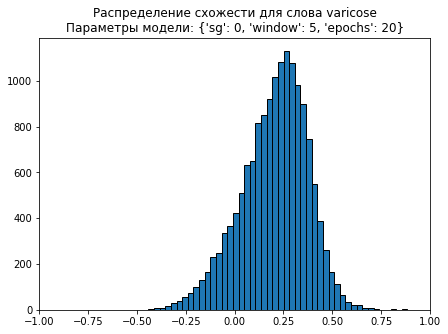

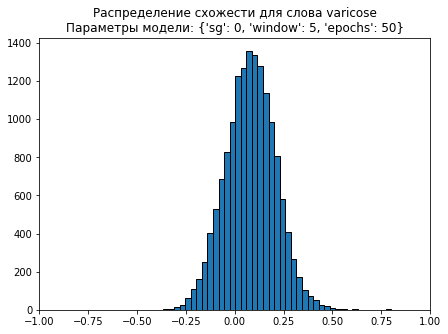

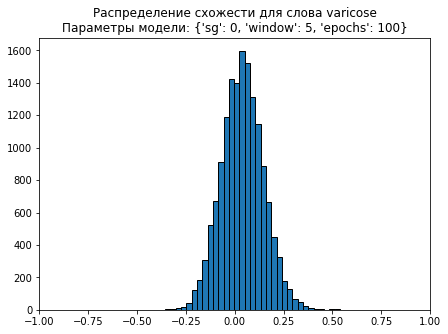

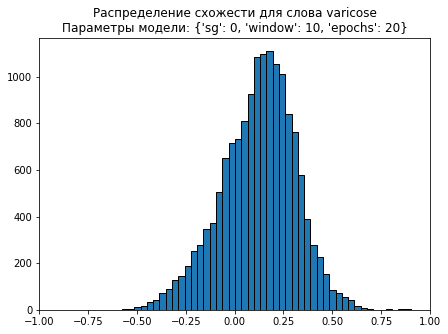

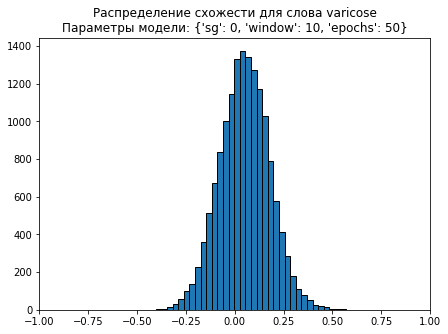

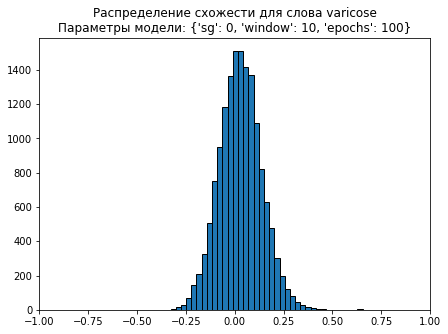

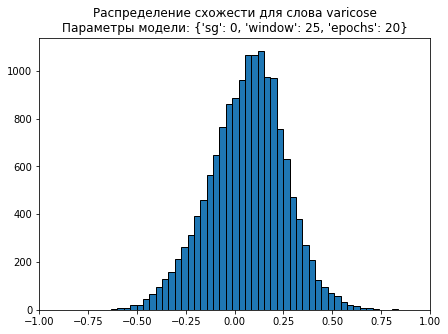

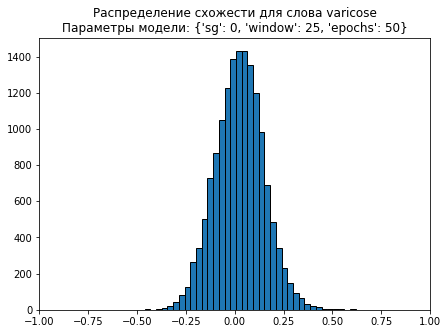

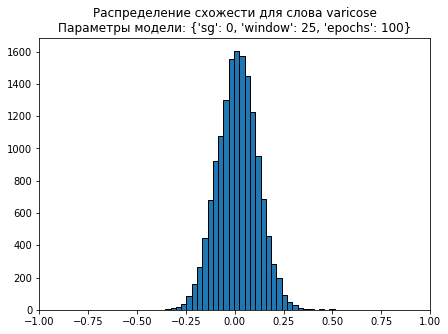

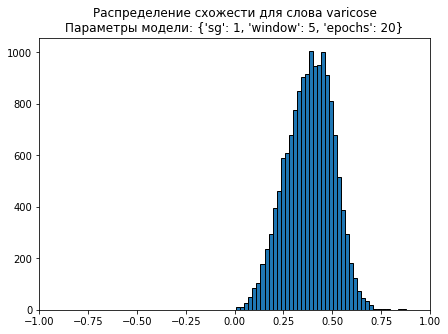

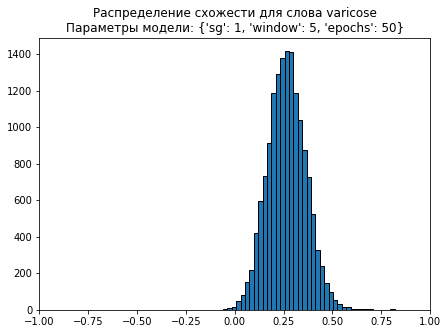

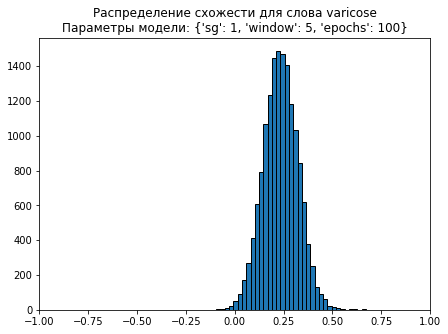

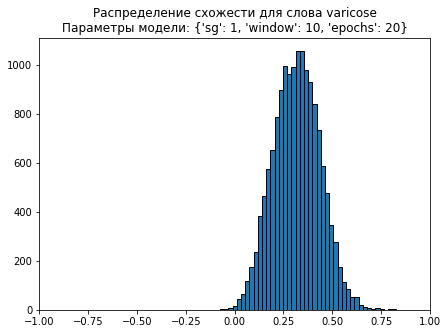

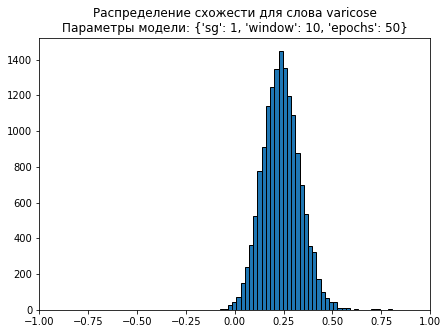

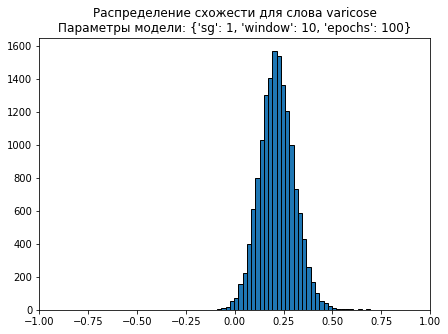

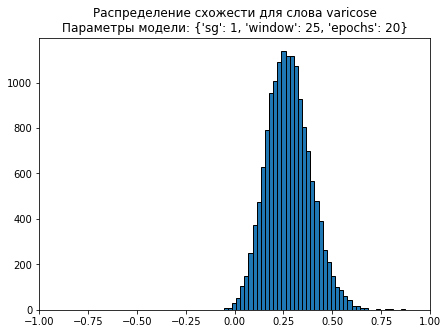

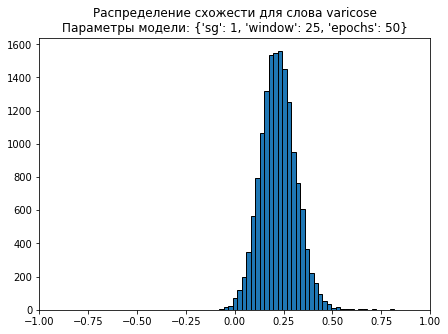

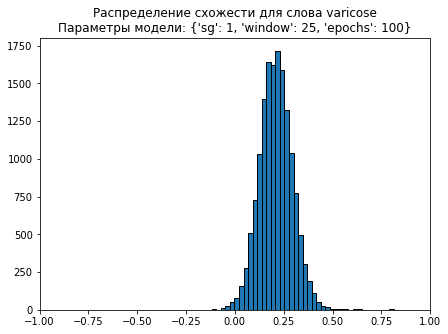

In [20]:
for k in run_record:
    params = {'sg': k.sg, 'window': k.window, 'epochs': k.epoch}
    show_similarity_for_single_word(run_record[k], params, 'varicose')

In [21]:
# run_record[Hyperparams(sg=0, window=10, epoch=50)].wv.most_similar('lstm')
best_model = run_record[Hyperparams(sg=0, window=10, epoch=50)]
best_model.wv.most_similar_cosmul('varicose')

[('vein', 0.895768404006958),
 ('saphenous', 0.8747982978820801),
 ('thread', 0.8636784553527832),
 ('sclerotherapy', 0.8442552089691162),
 ('stripping', 0.829933762550354),
 ('obliterate', 0.8164351582527161),
 ('deep', 0.7842217087745667),
 ('saphenofemoral', 0.7795426845550537),
 ('incompetent', 0.7717968225479126),
 ('duplex', 0.7655010223388672)]

In [22]:
word = 'varicose'
matrix_word = cosine_similarity(best_model.wv[word].reshape(1, -1), best_model.wv.vectors)

In [23]:
for v in best_model.wv.most_similar('varicose'):
    print(f'{v[0]:<20} {v[1]:.3f}')    

vein                 0.792
saphenous            0.750
thread               0.727
sclerotherapy        0.689
stripping            0.660
obliterate           0.633
deep                 0.568
saphenofemoral       0.559
incompetent          0.544
duplex               0.531


In [24]:
from fitter import Fitter, get_common_distributions, get_distributions

f = Fitter(matrix_word,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
# f.summary()
f.fitted_param['norm']

(0.049931392, 0.12826201)